# Regularization Techniques

Ref:    
* https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
* https://yceffort.kr/2019/02/13/pytorch-fashion-MNIST

본 실습에서는 FashionMNIST data를 활용하였습니다.

<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2023-2/blob/main/ML_day7/7_5_Regularization_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from torchsummary import summary

## Load Data (FashionMNIST)

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████████████████████████████████████████████████████████████| 26421880/26421880 [02:22<00:00, 185718.11it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 107327.51it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:12<00:00, 341245.23it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 5139794.57it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



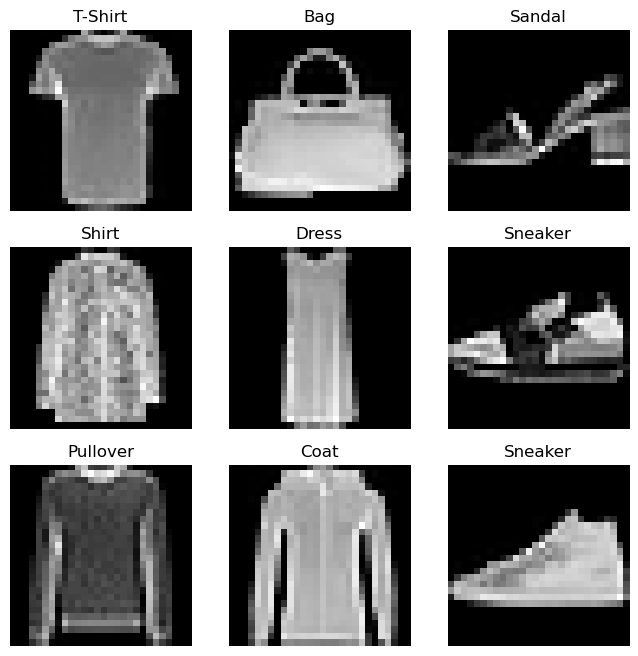

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
batch_size = 32

In [5]:
train_dataloader = DataLoader(
    training_data, 
    batch_size=batch_size, 
    shuffle=True
)

test_dataloader = DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=True
)

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


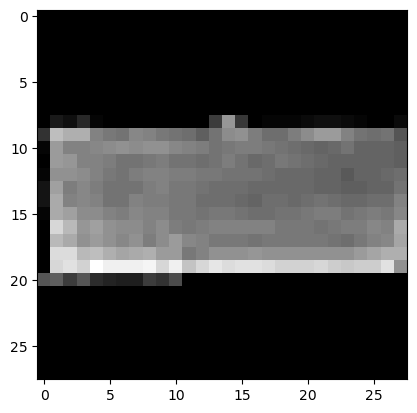

Label: 8 (labels_map[int(label)])


In [6]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label} (labels_map[int(label)])")

In [7]:
len(training_data)

60000

In [8]:
len(train_dataloader)

1875

## Build Neural Network with Regularization & Normalization Techniques

Prominent Techniques
* Batch Normalization: **Internal Covariance Shift** 방지
* Dropout: **Overfitting** 방지

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 2**8)
        self.fc2 = nn.Linear(2**8, 2**6)
        self.fc3 = nn.Linear(2**6, 2**5)
        self.fc4 = nn.Linear(2**5, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.softmax(x, dim=1)
        return x

In [10]:
class NetBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 2**8)
        self.bn1 = nn.BatchNorm1d(2**8)
        self.fc2 = nn.Linear(2**8, 2**6)
        self.bn2 = nn.BatchNorm1d(2**6)
        self.fc3 = nn.Linear(2**6, 2**5)
        self.fc4 = nn.Linear(2**5, 10)
        
    def forward(self, x):
        # same as torch.flatten(x,1)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.softmax(x, dim=1)
        return x

In [11]:
class NetDO(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 2**8)
        self.fc2 = nn.Linear(2**8, 2**6)
        self.fc3 = nn.Linear(2**6, 2**5)
        self.fc4 = nn.Linear(2**5, 10)
        self.dropout1 = nn.Dropout(p=0.8)
        self.dropout2 = nn.Dropout(p=0.5)
        
    def forward(self, x):
        # same as x.view(x.size(0), -1)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.softmax(x, dim=1)
        return x

## Train the Network

### Select loss function, optimizer, learning rate scheduler

In [12]:
num_epochs = 20

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
net_nn = Net()
net_bn = NetBN()
net_do = NetDO()

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
optimizer_nn = optim.Adam(
    net_nn.parameters(), 
    lr=0.001, 
)

In [17]:
optimizer_bn = optim.Adam(
    net_bn.parameters(), 
    lr=0.001, 
)

In [18]:
optimizer_do = optim.Adam(
    net_do.parameters(), 
    lr=0.001, 
)

`torch.optim.lr_scheduler.StepLR()`: step_size마다 gamma의 비율로 learning_rate 감소

In [19]:
scheduler_nn = torch.optim.lr_scheduler.StepLR(optimizer_nn, step_size= 5, gamma=0.8)

In [20]:
scheduler_bn = torch.optim.lr_scheduler.StepLR(optimizer_bn, step_size= 5, gamma=0.8)

In [21]:
scheduler_do = torch.optim.lr_scheduler.StepLR(optimizer_do, step_size= 5, gamma=0.8)

### Define `train(net, optimizer, scheduler, path_name)` Function

In [22]:
def train(net, optimizer, scheduler, path_name):
    
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        # set train mode
        net.train()
        
        # training
        running_loss = 0.0

        for inputs, labels in train_dataloader:

            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = net(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        # adjust learning rate with scheduler
        scheduler.step()


        # evaluation(validation)
        test_loss = 0.0
        accuracy = 0.0

        # turn off grardients for validation
        with torch.no_grad():
            
            # set evaluation (test) mode
            net.eval()
            
            for inputs, labels in test_dataloader:

                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)

                test_loss += criterion(outputs, labels)

                # 로그 확률에 지수 적용
                ps = torch.exp(outputs)

                # topk는 k번째로 큰 숫자를 찾아내는 것
                # dim=1 는 dimension을 의미
                top_p, top_class = ps.topk(1, dim=1)


                # labels를 top_class와 똑같은 형태로 만든다음에, 얼마나 같은게 있는지 확인한다.
                equals = top_class == labels.view(*top_class.shape)


                # equals를 float으로 바꾸고 평균 정확도를 구한다.
                accuracy += torch.mean(equals.type(torch.FloatTensor))


        test_accuracy = accuracy / len(test_dataloader)

        current_train_loss = running_loss / len(train_dataloader)
        current_test_loss = test_loss / len(test_dataloader)

        train_losses.append(current_train_loss)
        test_losses.append(current_test_loss.detach().cpu().numpy())

        print(
            f"Epoch: {epoch+1} / {num_epochs}..", 
            "Training Loss: {:.5f}..  ".format(current_train_loss),
            "Test Loss: {:.5f}..  ".format(current_test_loss),        
            "Test Accuracy: {:.3f}".format(test_accuracy)

        )
        
    # save trained model
    PATH = f'./{path_name}.pth'
    torch.save(net.state_dict(), PATH)
        
    return train_losses, test_losses

### Näive Neural Net

In [23]:
net = net_nn
optimizer = optimizer_nn
scheduler = scheduler_nn

In [24]:
net = net.to(device)

In [25]:
summary(net, (1,28,28), batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [32, 256]         200,960
            Linear-2                   [32, 64]          16,448
            Linear-3                   [32, 32]           2,080
            Linear-4                   [32, 10]             330
Total params: 219,818
Trainable params: 219,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.09
Params size (MB): 0.84
Estimated Total Size (MB): 1.02
----------------------------------------------------------------


In [26]:
train_loss_list_nn, test_loss_list_nn = train(net=net, optimizer=optimizer, scheduler=scheduler, path_name='FMNIST_nn_naive')

Epoch: 1 / 20.. Training Loss: 1.69310..   Test Loss: 1.64083..   Test Accuracy: 0.822
Epoch: 2 / 20.. Training Loss: 1.63379..   Test Loss: 1.63123..   Test Accuracy: 0.829
Epoch: 3 / 20.. Training Loss: 1.62040..   Test Loss: 1.62197..   Test Accuracy: 0.839
Epoch: 4 / 20.. Training Loss: 1.61401..   Test Loss: 1.61694..   Test Accuracy: 0.844
Epoch: 5 / 20.. Training Loss: 1.60814..   Test Loss: 1.60920..   Test Accuracy: 0.852
Epoch: 6 / 20.. Training Loss: 1.60116..   Test Loss: 1.61378..   Test Accuracy: 0.847
Epoch: 7 / 20.. Training Loss: 1.59753..   Test Loss: 1.62246..   Test Accuracy: 0.838
Epoch: 8 / 20.. Training Loss: 1.59593..   Test Loss: 1.60947..   Test Accuracy: 0.850
Epoch: 9 / 20.. Training Loss: 1.59109..   Test Loss: 1.61534..   Test Accuracy: 0.846
Epoch: 10 / 20.. Training Loss: 1.58919..   Test Loss: 1.62377..   Test Accuracy: 0.836
Epoch: 11 / 20.. Training Loss: 1.58420..   Test Loss: 1.59387..   Test Accuracy: 0.867
Epoch: 12 / 20.. Training Loss: 1.58178..

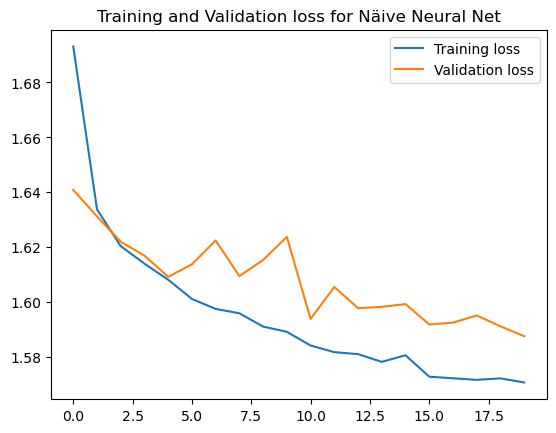

In [27]:
plt.plot(train_loss_list_nn, label='Training loss')
plt.plot(test_loss_list_nn, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss for Näive Neural Net')
plt.show()

### Neural Network with Batch Normalization

In [28]:
net = net_bn
optimizer = optimizer_bn
scheduler = scheduler_bn

In [29]:
net = net.to(device)

In [30]:
summary(net, (1,28,28), batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [32, 256]         200,960
       BatchNorm1d-2                  [32, 256]             512
            Linear-3                   [32, 64]          16,448
       BatchNorm1d-4                   [32, 64]             128
            Linear-5                   [32, 32]           2,080
            Linear-6                   [32, 10]             330
Total params: 220,458
Trainable params: 220,458
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.17
Params size (MB): 0.84
Estimated Total Size (MB): 1.10
----------------------------------------------------------------


In [31]:
train_loss_list_bn, test_loss_list_bn = train(net=net, optimizer=optimizer, scheduler=scheduler, path_name='FMNIST_nn_batchnorm')

Epoch: 1 / 20.. Training Loss: 1.68898..   Test Loss: 1.63618..   Test Accuracy: 0.823
Epoch: 2 / 20.. Training Loss: 1.62095..   Test Loss: 1.61400..   Test Accuracy: 0.846
Epoch: 3 / 20.. Training Loss: 1.60899..   Test Loss: 1.62483..   Test Accuracy: 0.836
Epoch: 4 / 20.. Training Loss: 1.60157..   Test Loss: 1.60428..   Test Accuracy: 0.856
Epoch: 5 / 20.. Training Loss: 1.59294..   Test Loss: 1.61376..   Test Accuracy: 0.846
Epoch: 6 / 20.. Training Loss: 1.58447..   Test Loss: 1.59830..   Test Accuracy: 0.863
Epoch: 7 / 20.. Training Loss: 1.58229..   Test Loss: 1.59264..   Test Accuracy: 0.868
Epoch: 8 / 20.. Training Loss: 1.57816..   Test Loss: 1.58997..   Test Accuracy: 0.871
Epoch: 9 / 20.. Training Loss: 1.57605..   Test Loss: 1.59624..   Test Accuracy: 0.863
Epoch: 10 / 20.. Training Loss: 1.57423..   Test Loss: 1.58599..   Test Accuracy: 0.874
Epoch: 11 / 20.. Training Loss: 1.56811..   Test Loss: 1.58533..   Test Accuracy: 0.876
Epoch: 12 / 20.. Training Loss: 1.56654..

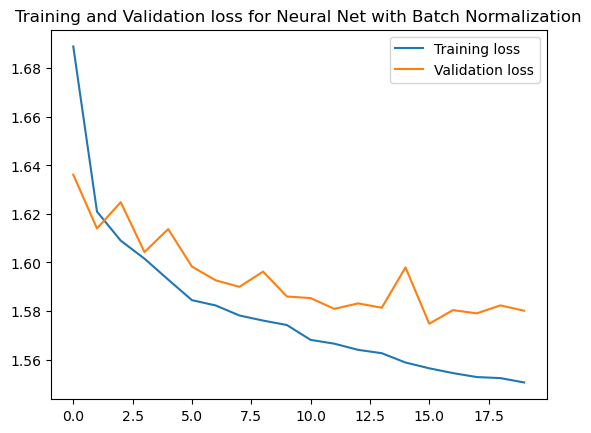

In [32]:
plt.plot(train_loss_list_bn, label='Training loss')
plt.plot(test_loss_list_bn, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss for Neural Net with Batch Normalization')
plt.show()

### Neural Network with Dropout

In [33]:
net = net_do
optimizer = optimizer_do
scheduler = scheduler_do

In [34]:
net = net.to(device)

In [35]:
summary(net, (1,28,28), batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [32, 256]         200,960
           Dropout-2                  [32, 256]               0
            Linear-3                   [32, 64]          16,448
           Dropout-4                   [32, 64]               0
            Linear-5                   [32, 32]           2,080
            Linear-6                   [32, 10]             330
Total params: 219,818
Trainable params: 219,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.17
Params size (MB): 0.84
Estimated Total Size (MB): 1.10
----------------------------------------------------------------


In [36]:
train_loss_list_do, test_loss_list_do = train(net=net, optimizer=optimizer, scheduler=scheduler, path_name='FMNIST_nn_dropout')

Epoch: 1 / 20.. Training Loss: 1.86932..   Test Loss: 1.70344..   Test Accuracy: 0.758
Epoch: 2 / 20.. Training Loss: 1.75131..   Test Loss: 1.69013..   Test Accuracy: 0.769
Epoch: 3 / 20.. Training Loss: 1.73223..   Test Loss: 1.67639..   Test Accuracy: 0.783
Epoch: 4 / 20.. Training Loss: 1.72505..   Test Loss: 1.66888..   Test Accuracy: 0.790
Epoch: 5 / 20.. Training Loss: 1.71813..   Test Loss: 1.67192..   Test Accuracy: 0.787
Epoch: 6 / 20.. Training Loss: 1.70425..   Test Loss: 1.66855..   Test Accuracy: 0.793
Epoch: 7 / 20.. Training Loss: 1.69938..   Test Loss: 1.65708..   Test Accuracy: 0.804
Epoch: 8 / 20.. Training Loss: 1.69709..   Test Loss: 1.65540..   Test Accuracy: 0.806
Epoch: 9 / 20.. Training Loss: 1.69407..   Test Loss: 1.65130..   Test Accuracy: 0.809
Epoch: 10 / 20.. Training Loss: 1.69485..   Test Loss: 1.65758..   Test Accuracy: 0.803
Epoch: 11 / 20.. Training Loss: 1.68947..   Test Loss: 1.64644..   Test Accuracy: 0.814
Epoch: 12 / 20.. Training Loss: 1.68530..

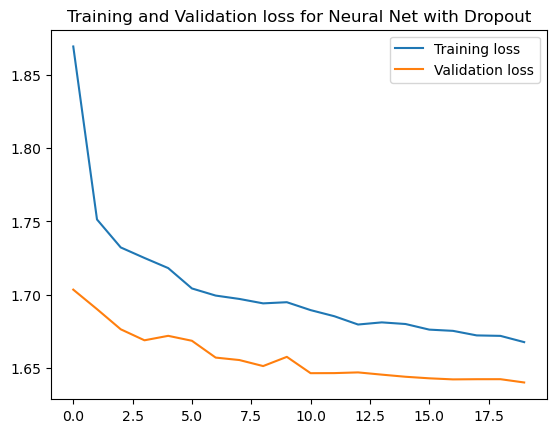

In [37]:
plt.plot(train_loss_list_do, label='Training loss')
plt.plot(test_loss_list_do, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss for Neural Net with Dropout')
plt.show()